## 1. Importing Libra and other dependencies <a name="import"></a>

Import Libra and other dependencies such as numpy and matplotlib

In [1]:
import os
import sys
import time
import math

# Fisrt, we add the location of the library to test to the PYTHON path
from liblibra_core import *
from libra_py import units
import libra_py.workflows.nbra.lz as lz
import libra_py.workflows.nbra.step4 as step4
from libra_py import data_visualize
from libra_py import data_conv, data_stat, data_outs, data_read
from libra_py import pdos, spectrum
from libra_py import fit
import libra_py.workflows.nbra.decoherence_times as decoherence_times
from libra_py import influence_spectrum
import util.libutil as comn

import numpy as np
import matplotlib.pyplot as plt

colors = {}
colors.update({"1": '#000000'})  # Black 
colors.update({"2": '#000099'})  # Blue  
colors.update({"3": '#006400'})  # Green 
colors.update({"4": '#990000'})  # Red   
colors.update({"5": '#8B008B'})  # Purple
colors.update({"6": '#FF8C00'})  # Orange
colors.update({"9": '#4d4d4d'})  # Gray  
color_index = ["1","2","3","4","5","6","9"]


colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24",
              "11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24",
              "11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"  ]


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::v

In [9]:
!tar -xf all_logfiles.tar.bz2
!tar -xf all_pdosfiles.tar.bz2
!tar -xf res.tar.bz2
!tar -xf res_mb_sp.tar.bz2

## 2. pDOS

In [2]:
# pDOS calculations
s_proj = [ ["s"], [], ["P"] ]
p_proj = [ ["px", "py", "pz"], [], ["P"] ]
d_proj = [ ["d-2", "d-1", "d0", "d+1", "d+2"], [], ["P"] ]

pdos_params = {"prefix": "all_pdosfiles/pristine", 
               "snapshots": list(range(5000, 7000)) , 
               "projections":[ s_proj, p_proj, d_proj ], 
               "element_mapping": {"P":1}     
              }
E, pDOSa, pDOSb = pdos.cp2k_pdos( pdos_params )


multiplication factor is =  4
original grid spacing =  0.1
new grid spacing =  0.025
gaussian variance =  0.05
multiplication factor is =  4
original grid spacing =  0.1
new grid spacing =  0.025
gaussian variance =  0.05


In [3]:
def pdos_plot(plt, E, pDOSa, pDOSb, _params):    

    params = dict(_params)

    critical_params = [ ] 
    default_params = {"which_projections": [0], "labels": ["s"],  "colors": ["black"], "title":"No title" }
    comn.check_input(params, default_params, critical_params)

    which_projections = params["which_projections"]
    labels = params["labels"]
    colors = params["colors"]
    title = params["title"]


    e = data_conv.MATRIX2nparray(E)
    pdosa = data_conv.MATRIX2nparray(pDOSa)
    pdosb = data_conv.MATRIX2nparray(pDOSb)

    nplots = len(which_projections)

    figure = plt.figure(num=None, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)
   
    #plt.xticks(fontsize=8)
    #plt.yticks(fontsize=8)
    plt.xlim(-2.5, 2.5)
    #plt.ylim(0,nstates-1)
    
    # Plot the total density by black color
    for i in range(nplots):
        plt.plot(e[:, 0], pdosa[:, which_projections[i]], label=labels[i],color=colors[i], linewidth=2.0)
        
        
    plt.title(title,fontsize=12)
    plt.legend(fontsize=6.75, ncol=1, loc='upper center')
    plt.xlabel('$E - E_f$, eV',fontsize=12)
    plt.ylabel('pDOS, $eV^{-1}$',fontsize=12)

    plt.tight_layout()
    plt.savefig('pdosa.png', dpi=300)
    plt.show()


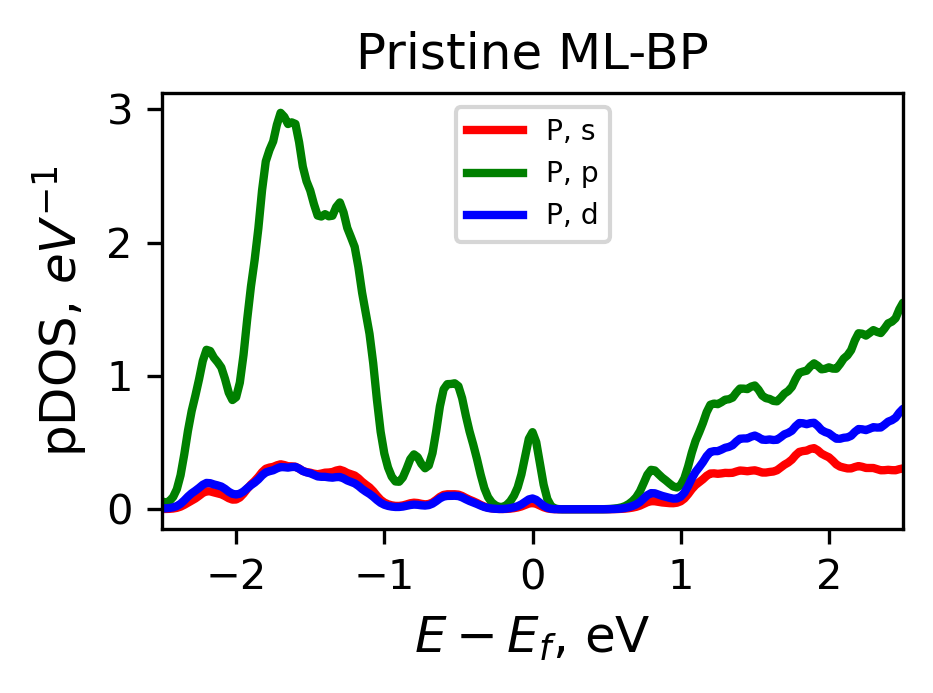

In [4]:
# Plotting
plotting_params = { "which_projections": [ 0, 1, 2],
                    "labels": ["P, s", "P, p", "P, d"], 
                    "colors": ["red", "green", "blue"],
                    "title": "Pristine ML-BP" 
                  }
                
pdos_plot(plt, E, pDOSa, pDOSb, plotting_params )

## 3. Optical spectrum

In [5]:
spec_params = {"prefix":"all_logfiles/step_",
               "snapshots": list(range(5000, 6999)),
               "states":list(range(1,11)),
               "emin":0.0, "emax":2.0, "de":0.1,
               "outfile_prefix":"absorption_", 
               "do_convolve":True, "de_new":0.025, "var": 0.05
               }
e, spec = spectrum.cp2k_spectrum(spec_params)

multiplication factor is =  4
original grid spacing =  0.1
new grid spacing =  0.025
gaussian variance =  0.05


In [6]:
def spectrum_plot(plt, E, spectr, _params):
    
    params = dict(_params)

    critical_params = [ ] 
    default_params = {"which_projections": [0], "labels": ["s"],  "colors": ["black"], 
                      "title":"No title", "output_prefix":"spectrum_"}
    comn.check_input(params, default_params, critical_params)

    which_projections = params["which_projections"]
    labels = params["labels"]
    colors = params["colors"]
    title = params["title"]
    out_prefix = params["output_prefix"]


    e = data_conv.MATRIX2nparray(E)
    spec = data_conv.MATRIX2nparray(spectr)

    nplots = len(which_projections)

    plt.figure(num=None, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)
   
    # Plot the total density by black color
    for i in range(nplots):
        plt.plot(e[:, 0], spec[:, which_projections[i]], label=labels[i],color=colors[i], linewidth=2.0)

    plt.title(title,fontsize=12)
    plt.legend(fontsize=6.75, ncol=1, loc='upper right')
    plt.xlabel('Energy, eV',fontsize=12)
    plt.ylabel('Absorbance',fontsize=12)

    plt.tight_layout()
    plt.savefig(F'{out_prefix}.png', dpi=300)
    plt.show()


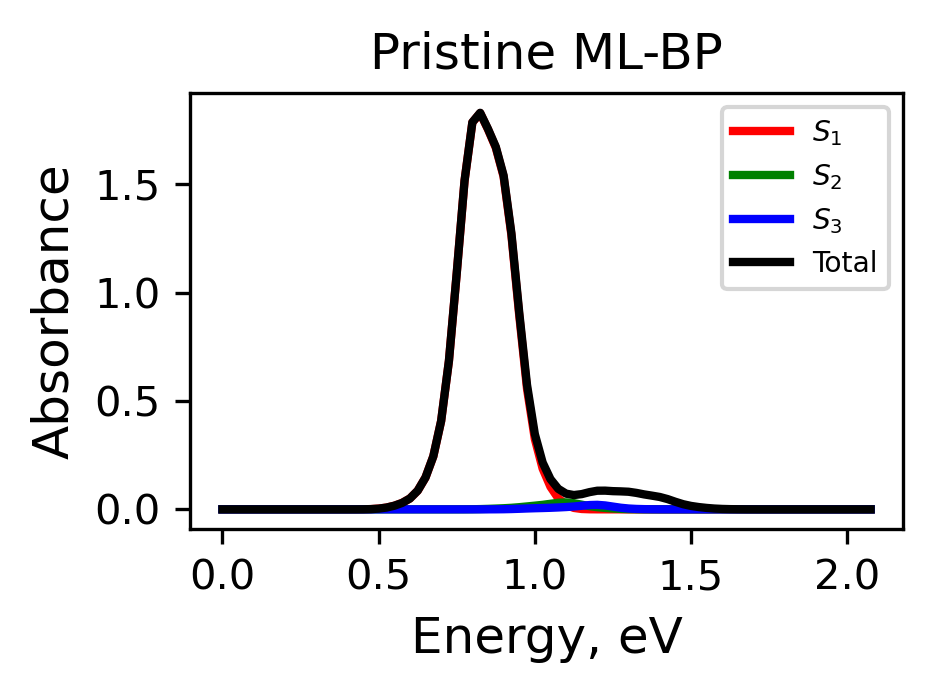

In [7]:
# Plotting
plotting_params = { "which_projections": [0, 1, 2, 10],
                    "labels": ["$S_1$", "$S_2$", "$S_3$", "Total"], 
                    "colors": ["red", "green", "blue", "black"],
                    "title": "Pristine ML-BP", "output_prefix":"spectrum_divac"
                  }

spectrum_plot(plt, e, spec, plotting_params )

## 4.  Energy levels vs. time and averaged NACs

In [8]:
print ("\nGathering data from MD ")
print ("Considering system", "Libra Tutorial: Single Rutile TiO2 Unit Cell - Kohn-Sham basis")

absolute_path = os.getcwd()
params = {}
params["data_set_paths"] = []
params["data_set_paths"].append(absolute_path+"/res_mb_sp/")

params["Hvib_re_prefix"] = "Hvib_ci_"; params["Hvib_re_suffix"] = "_re"
params["Hvib_im_prefix"] = "Hvib_ci_"; params["Hvib_im_suffix"] = "_im"
params["nfiles"]         = 1999
params["init_times"]     = [5000]
params["nstates"]        = 11 # total number of electronic states
params["active_space"]   = list(range(11)) # indexing is from 0!

# Include HOMO and up to the last electronic state
hvib = step4.get_Hvib2(params)
print ("Length of hvib is: ", len(hvib[0]))


Gathering data from MD 
Considering system Libra Tutorial: Single Rutile TiO2 Unit Cell - Kohn-Sham basis
Length of hvib is:  1999


In [9]:
def plot_hvib(Hvib, figname='energies_nacs-1.png'):

    ntraj  = len(Hvib)
    nsteps = len(Hvib[0])
    nCIs   = Hvib[0][0].num_of_cols

    # Make a list for the SD energies and populate it
    CI_energy = []
    md_time = list( range(nsteps) )
    for sd_index in range( nCIs ):
        CI_energy.append( [] )
        for step in range( nsteps ):        
            En = Hvib[0][step].get( sd_index, sd_index ).real 
            E0 = Hvib[0][step].get( 0, 0 ).real
            CI_energy[ sd_index ].append( En - E0 )        
        
    CI_energy  = np.array( CI_energy  )
    md_time    = np.array( md_time )

    # Compute the time-averaged CI NACs and make a list of them
    ci_res = data_stat.cmat_stat2(Hvib[0], 2)
    ci_tNACs = []
    for i in range(nCIs):
        ci_tNACs.append( [] )
        for j in range(nCIs):
            ci_tNACs[i].append( ci_res.get(i,j).imag * 1000.0 / units.ev2Ha )        
    ci_tNACs = np.array(ci_tNACs)

    nstates = 10

    # Figures - Time-Dependent Data
    plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
    plt.subplot(1,2,1)
    plt.ylim(0.5,2)
    plt.title('TD-DFT Energies', fontsize=8)
    plt.xlabel('Time, fs')
    plt.ylabel('$E-E_0$, eV')
    for state in range( nstates ):    
        if state==1:
            plt.plot(md_time, CI_energy[state]/units.ev2Ha, label="", linewidth=2, color = "red")
        elif state==2:
            plt.plot(md_time, CI_energy[state]/units.ev2Ha, label="", linewidth=2, color = "blue")            
        else:
            plt.plot(md_time, CI_energy[state]/units.ev2Ha, label="", linewidth=1, color = "black")
    plt.tight_layout()


    plt.subplot(1,2,2)
    plt.title('TD-DFT time-averaged NACs', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(0,nstates-1)
    plt.ylim(0,nstates-1)
    #plt.xticks([0,1,2,3,4,5,6,7,8,9])
    #plt.yticks([0,1,2,3,4,5,6,7,8,9])
    plt.xlabel('State index')
    plt.ylabel('State index')
    plt.imshow(ci_tNACs, cmap='hot', interpolation='nearest')
    cb = plt.colorbar(label="meV")
    cb.ax.tick_params(labelsize=8)

    plt.tight_layout()

    plt.savefig(figname, dpi=300)
    plt.show()


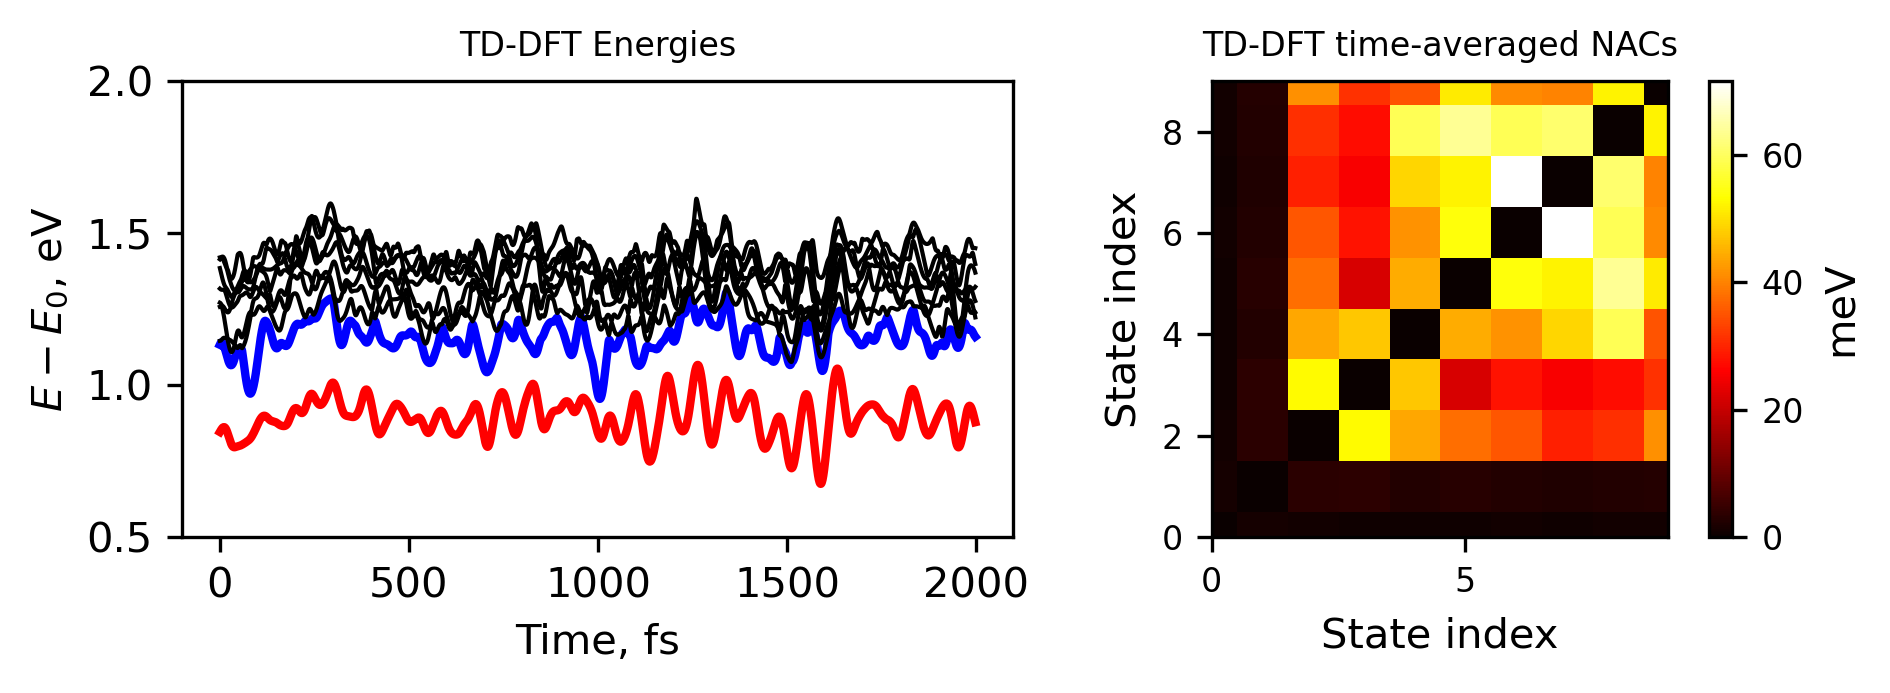

In [10]:
plot_hvib(hvib, 'energies_nacs-original.png')

## 5. Decoherence times and average gaps<a name="decoherence"></a>
[Return to Table of contents](#toc)

In [11]:
params["init_times"] = [0]
params["nsteps"] = 1999
# Compute energy gaps and decoherence times over part of the trajectory we want
tau, rates = decoherence_times.decoherence_times_ave(hvib, [params["init_times"][0]], params["nsteps"], 0)
de         = decoherence_times.energy_gaps_ave(      hvib, [params["init_times"][0]], params["nsteps"])
avg_deco   = tau/units.fs2au


In [12]:
print ("Decoherence time for GS / S1 =", tau.get(0,1)/units.fs2au, "fs")
params["decoherence_constants"] = 1
params["decoherence_times"]     = tau

Decoherence time for GS / S1 = 16.012162272318267 fs


In [13]:
def plot_dephasing_times(data, title, figname='dephasing_times.png'):
 
    nstates = 10
    
    # Figures - Time-Dependent Data
    plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)

    plt.subplot(1,1,1)
    plt.title(title, fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(0,nstates-1)
    plt.ylim(0,nstates-1)
    #plt.xticks([0,1,2,3,4,5,6,7,8,9])
    #plt.yticks([0,1,2,3,4,5,6,7,8,9])
    plt.xlabel('State index')
    plt.ylabel('State index')
    plt.imshow(data, cmap='hot', interpolation='nearest')
    cb = plt.colorbar(label="fs")
    cb.ax.tick_params(labelsize=8)
    plt.tight_layout()

    plt.savefig(figname, dpi=300)
    plt.show()


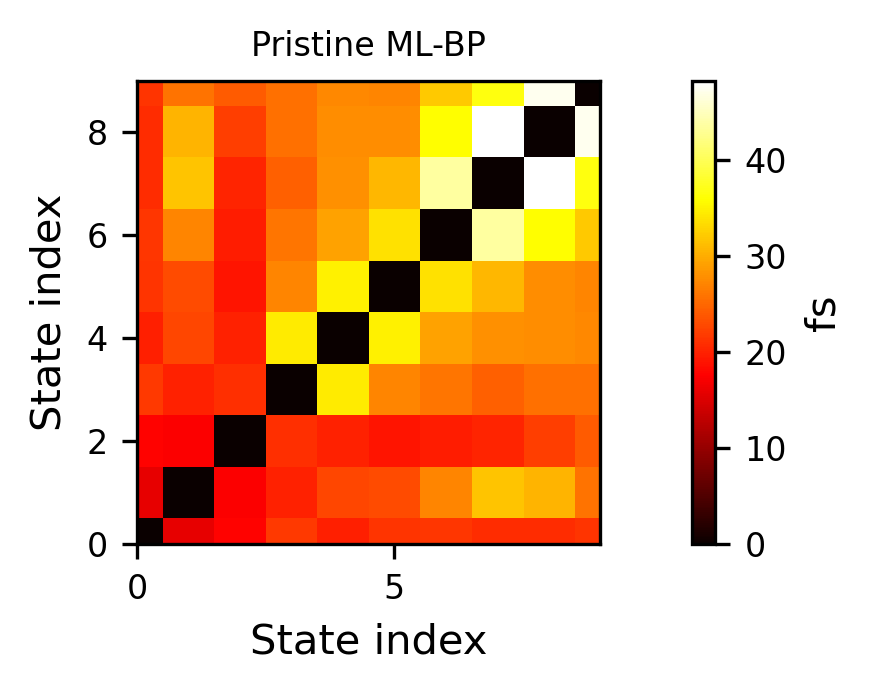

In [14]:
tau_ci = data_conv.MATRIX2nparray( tau ) * units.au2fs
for i in range( len(tau_ci) ):
    tau_ci[i][i] = 0.0

plot_dephasing_times(tau_ci, "Pristine ML-BP")

## 6. Average gaps and gap distributions

In [15]:
def get_avegage_energies(Hvib):
        
    nsteps = len(Hvib[0])
    nstates   = Hvib[0][0].num_of_cols

    # Make a list for the SD energies and populate it
    dE = [0.0]*nstates
        
    for step in range( nsteps ):
        for i in range( nstates ):
            dE[i] += Hvib[0][step].get( i, i ).real - Hvib[0][step].get( 0, 0 ).real 
            
    for i in range( nstates ):
        dE[i] = dE[i] / nsteps
        
    return dE

In [16]:
dE = get_avegage_energies(hvib)

print("Average energies above the GS are")
for indx, e_gap in enumerate(dE):
    print(F"State {indx} energy {e_gap * units.au2ev} eV")

Average energies above the GS are
State 0 energy 0.0 eV
State 1 energy 0.8939444118396147 eV
State 2 energy 1.1539709380255396 eV
State 3 energy 1.2255421659223276 eV
State 4 energy 1.272161963447157 eV
State 5 energy 1.3135713854880529 eV
State 6 energy 1.3579016458928461 eV
State 7 energy 1.3912415005995948 eV
State 8 energy 1.422780868013126 eV
State 9 energy 1.4544218860715266 eV
State 10 energy 1.4905279286429909 eV


In [17]:
def gap_distrib_plot(plt, gaps, states, title):
    
    """
    params = dict(_params)

    critical_params = [ ] 
    default_params = {"which_projections": [0], "labels": ["s"],  "colors": ["black"], 
                      "title":"No title", "output_prefix":"spectrum_"}
    comn.check_input(params, default_params, critical_params)

    which_projections = params["which_projections"]
    labels = params["labels"]
    colors = params["colors"]
    title = params["title"]
    out_prefix = params["output_prefix"]


    e = data_conv.MATRIX2nparray(E)
    spec = data_conv.MATRIX2nparray(spectr)

    nplots = len(which_projections)
    
    """

    plt.figure(num=None, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)
   
    nst = len(states)
   
    cnt = 0
    for i in range(nst):
        st1 = states[i]
        for j in range(i+1, nst):
            st2 = states[j]        
            
            if cnt==0:
                cl = "black"
            elif cnt==1:
                cl = "blue"
            elif cnt==2:
                cl = "red"
            else:
                cl = colors[color_index[cnt]]
            
            
            bin_supp, dens, cum = data_stat.cmat_distrib(gaps, st1, st2, 0, 0.0, 0.075, 0.001) 
            
            e = np.array(bin_supp) * units.au2ev
            plt.plot( e, dens, label=F'$|E_{st1}-E_{st2}|$', linewidth=2, color = cl)     
        
            
            cnt = cnt + 1
        

    plt.title(title,fontsize=12)
    plt.legend(fontsize=6.75, ncol=1, loc='upper right')
    plt.xlabel('Energy gap, eV',fontsize=12)
    plt.ylabel('DOS',fontsize=12)

    plt.tight_layout()
    plt.savefig(F'gap_distributions.png', dpi=300)
    plt.show()


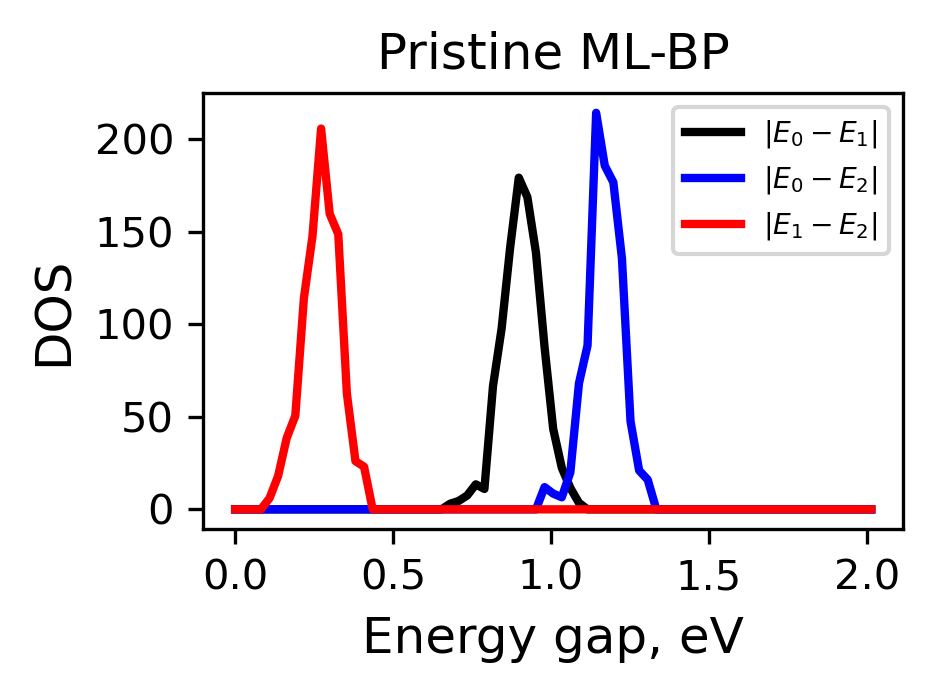

In [18]:
states = [0, 1, 2]

gap_distrib_plot(plt, de, [0, 1, 2], "Pristine ML-BP")

## 7. Influence spectrum

In [19]:
infsp_params = {}
infsp_params["dt"] = 1.0        # MD timestep in fs
infsp_params["wspan"] = 1000.0  #  cm^-1
infsp_params["dw"] = 1.0        # cm^-1
infsp_params["do_output"] = False
infsp_params["do_center"] = True
infsp_params["acf_type"] = 0
infsp_params["data_type"] = 0


states = [0, 1, 2]
nst = len(states)

T, ACF, W, J2 = [], [], [], []
for i in range(nst):
    for j in range(i+1,nst):
        
        data_ij = []        
        for de_ij in de:
            x = MATRIX(1,1)
            x.set(0,0, de_ij.get(i,j))
            data_ij.append(x)

        Tij, ACFij, uACFij, Wij, Jij, J2ij = influence_spectrum.recipe1(data_ij, infsp_params)
        
        T.append(Tij)
        ACF.append(ACFij)
        W.append(Wij)
        J2.append(J2ij)


In [21]:
sz = len(W[0])
for i in range(sz):
    print(F"i W = {W[0][i]}  J2_01 = {J2[0][i]}  J2_02 = {J2[1][i]}  J2_12 = {J2[2][i]}")

i W = 0.0  J2_01 = 161391.8756025341  J2_02 = 1301374.9180029072  J2_12 = 50437.61758533736
i W = 1.0  J2_01 = 136670.84300435608  J2_02 = 1143955.8424913525  J2_12 = 48670.32838495706
i W = 2.0  J2_01 = 77256.0376405926  J2_02 = 747984.7365426086  J2_12 = 43332.351987457936
i W = 3.0  J2_01 = 19359.587892680218  J2_02 = 305177.69772519986  J2_12 = 34492.236943157855
i W = 4.0  J2_01 = 757.4121847597964  J2_02 = 29417.923771944803  J2_12 = 22830.46066783425
i W = 5.0  J2_01 = 39479.76581416223  J2_02 = 52944.61502452672  J2_12 = 10381.888683919815
i W = 6.0  J2_01 = 122470.68875996622  J2_02 = 362611.3079476938  J2_12 = 1297.55782670103
i W = 7.0  J2_01 = 210653.58539570888  J2_02 = 807082.0322555314  J2_12 = 2278.3099916365027
i W = 8.0  J2_01 = 258471.84854844032  J2_02 = 1171049.3547141827  J2_12 = 22280.25875640707
i W = 9.0  J2_01 = 238370.66669605207  J2_02 = 1279854.7401714714  J2_12 = 71208.71705394634
i W = 10.0  J2_01 = 157718.10756370844  J2_02 = 1083294.6593704112  J2_12 = 

In [24]:
def find_maxima(w, data, fraction_tol):
    res = []
    n = len(data)
    
    for i in range(1,n-1):
        if data[i] > data[i+1] and data[i] > data[i-1]:
            res.append([ i, data[i]])
            
    res_srtd = merge_sort(res)
    
    n = len(res_srtd)
    
    final_res = []
    for i in range(n):
        I = res_srtd[n-1-i][0]
        j2 = res_srtd[n-1-i][1]
        final_res.append( [w[I], j2] )
        
    
    max_j2 = final_res[0][1]
    
    leading_freqs = [ final_res[0][0] ]
    for i in range(1,n):
        if (final_res[i][1]/ final_res[0][1]) > fraction_tol:
            leading_freqs.append( final_res[i][0] )
                
    return final_res, leading_freqs



max01 = find_maxima(W[0], J2[0], 0.001)
max02 = find_maxima(W[1], J2[1], 0.001)
max12 = find_maxima(W[2], J2[2], 0.001)


for i in range(10):
    print(F"i = {i} J2_01 = {max01[0][i]}  J2_02 = {max02[0][i]}  J2_12 = {max12[0][i]}")

#print("Maxima of 01: ", max01[0])
#print("Maxima of 02: ", max02[0])
#print("Maxima of 12: ", max12[0])

i = 0 J2_01 = [69.0, 35984427.12394776]  J2_02 = [69.0, 51217153.42082811]  J2_12 = [368.0, 49530909.39651492]
i = 1 J2_01 = [455.0, 35781821.738827005]  J2_02 = [94.0, 14418157.211847069]  J2_12 = [456.99999999999994, 33064634.74422534]
i = 2 J2_01 = [371.0, 18447984.9554521]  J2_02 = [447.0, 6515556.159672215]  J2_12 = [444.0, 3088876.017649804]
i = 3 J2_01 = [347.0, 6774528.793029885]  J2_02 = [83.0, 6317766.891121356]  J2_12 = [328.0, 2773118.1303933905]
i = 4 J2_01 = [91.0, 5599758.7110362565]  J2_02 = [217.0, 5418494.849099068]  J2_12 = [355.0, 2627068.8143361495]
i = 5 J2_01 = [81.0, 3756368.5324421246]  J2_02 = [349.0, 4755489.398362997]  J2_12 = [434.0, 2288305.521782023]
i = 6 J2_01 = [57.0, 1269538.4835387105]  J2_02 = [43.0, 3834895.3828964294]  J2_12 = [150.0, 2156005.6714216443]
i = 7 J2_01 = [358.0, 1245818.5147965793]  J2_02 = [53.99999999999999, 3608527.0342373727]  J2_12 = [257.0, 1800440.5450394305]
i = 8 J2_01 = [211.0, 1113544.3986499885]  J2_02 = [467.000000000000

No handles with labels found to put in legend.


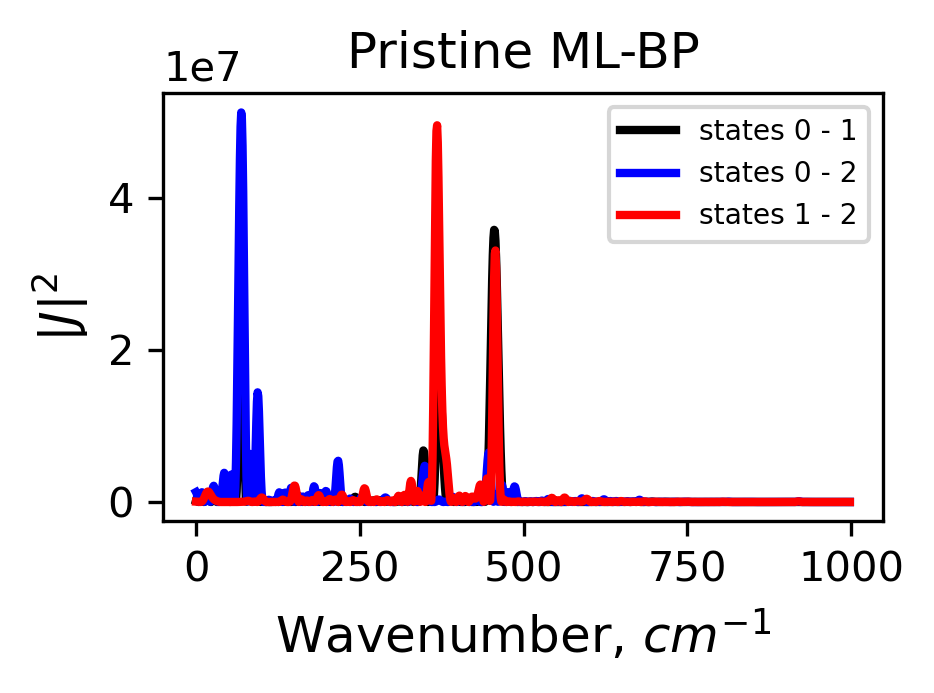

In [23]:
plt.figure(num=None, figsize=(3.21*1, 2.41), dpi=300, edgecolor='black', frameon=True)

"""
plt.subplot(1,2,1)
plt.title('ACF', fontsize=12)
plt.xlabel('Time, fs', fontsize=12)
plt.ylabel('ACF', fontsize=12)
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=12)

cnt = 0
for i in range(nst):
    st1 = states[i]
    for j in range(i+1,nst):
        st2 = states[j]
        
        if cnt==0:
            cl = "black"
        elif cnt==1:
            cl = "blue"
        elif cnt==2:
            cl = "red"
        else:
            cl = colors[color_index[cnt]]
        
        plt.plot(T[cnt], ACF[cnt], label='ACF for gap %i - %i' % (st1, st2), linewidth=2, color = cl) 
        cnt = cnt + 1
plt.legend(fontsize=6.75)
"""

#plt.subplot(1,2,2)
plt.title('Pristine ML-BP',fontsize=12)
plt.legend(fontsize=6.75, ncol=1, loc='upper right')
plt.xlabel('Wavenumber, $cm^{-1}$',fontsize=12)
plt.ylabel('$|J|^2$',fontsize=12)
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=12)

cnt = 0
for i in range(nst):
    st1 = states[i]
    for j in range(i+1,nst):
        st2 = states[j]     
        
        if cnt==0:
            cl = "black"
        elif cnt==1:
            cl = "blue"
        elif cnt==2:
            cl = "red"
        else:
            cl = colors[color_index[cnt]]
        
        plt.plot(W[cnt], J2[cnt], label=F'states {st1} - {st2}', linewidth=2, color = cl) 
        cnt = cnt + 1
plt.legend(fontsize=6.75)

plt.tight_layout()
plt.savefig("acf-IFS.png", dpi=300)
plt.show()
plt.close()
    